In [17]:
# Nếu chưa có thư viện thì run cell này
!pip install mediapipe
!pip install pandas
!pip install numpy
!pip install celluloid

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd

In [3]:
label = {'Your': 1,
         'Love': 2,
         'Sleep': 3,
         'Name': 4,
         'What': 5,
         'Read': 6,
         'I': 7,
         'Bye': 8,
         'You': 9,
         'Eat': 10,
         'Hello': 11}

In [4]:
# Chọn những điểm cần thiết
indexPoseLandmark = [0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
indexHandLandmark = [0, 3, 4, 5, 8, 9, 12, 13, 16, 17, 20]
len(indexHandLandmark)

11

In [5]:
#  Folder data
root = './PhanLoai/'

# Test read with 1 File

In [6]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands

# For static images:
IMAGE_FILES = []
BG_COLOR = (192, 192, 192)  # gray

# For webcam input:
filenames = ['Sleep/Sleep0.avi', 'Eat/Eat3.avi', 'I/I2.avi', 'You/You1.avi' ] 
features = [[] for _ in range(len(filenames))]
for i, filename in enumerate(filenames):
    filename = root+filename
    cap = cv2.VideoCapture(filename)
    with mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=2,
            min_detection_confidence=0.5) as hands:
        with mp_pose.Pose(
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5) as pose:
            while True:
                success, image = cap.read()
                if not success:
                    cap = cv2.VideoCapture(filename)
                    # continue
                    break

                # To improve performance, optionally mark the image as not writeable to
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # HANDS
                hand_results = hands.process(image)
                #  GET HAND FEATURES
                hand_feature = []
                if hand_results.multi_hand_landmarks:
                    hand_feature = np.array([[lm.x, lm.y, lm.z] for lm in np.array(
                        hand_results.multi_hand_landmarks[0].landmark)[indexHandLandmark]])
                else:
                    hand_feature = np.array([[0, 0, 0] for i in range(len(indexHandLandmark))])

                # Draw the hand annotation on the image.
                if hand_results.multi_hand_landmarks:
                    for hand_landmarks in hand_results.multi_hand_landmarks:
                        mp_drawing.draw_landmarks(
                            image,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())

                # POSES
                pose_results = pose.process(image)
                #  GET POSE FEATURES
                pose_feature = []
                if pose_results.pose_landmarks:
                    pose_feature = np.array([[lm.x, lm.y, lm.z]
                                            for lm in np.array(pose_results.pose_landmarks.landmark)[indexPoseLandmark]])
                else:
                    pose_feature = np.array([[0, 0, 0] for i in range(len(indexPoseLandmark))])

                # Draw the pose annotation on the image.
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                mp_drawing.draw_landmarks(
                    image,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

                # Append to list feature
                features[i].append(np.concatenate((pose_feature, hand_feature)))

                # Flip the image horizontally for a selfie-view display.
                cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
                if cv2.waitKey(1) == ord('q'):
                    break
    cv2.destroyAllWindows()
cap.release()


# Show feature by scatter plot and compare

MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.


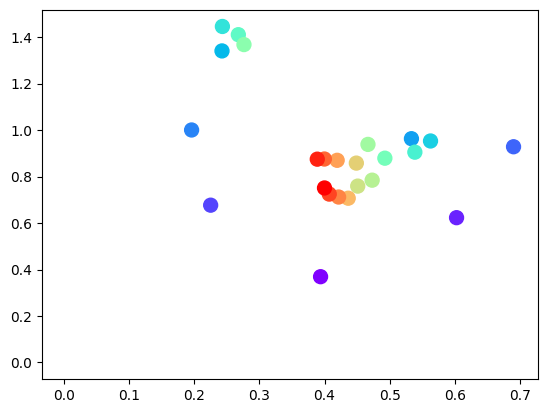

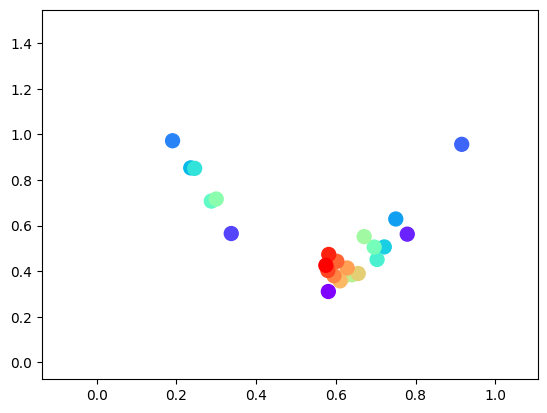

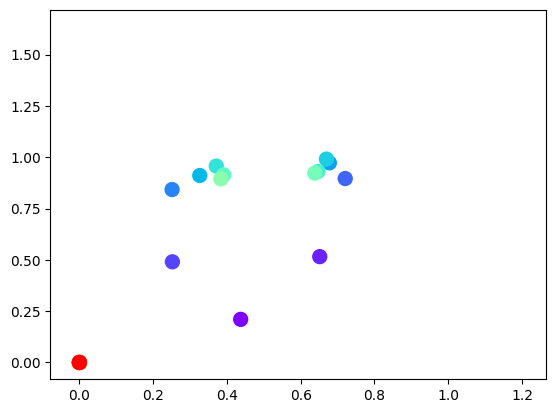

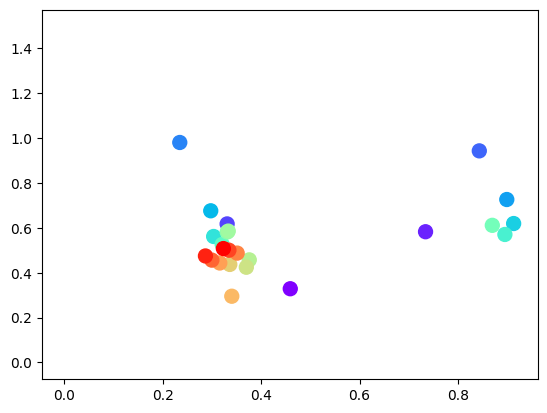

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera

for i, filename in enumerate(filenames):
    numpoints = len(features[i][0][:])
    points = np.array(features[i][0])[:, 0], np.array(features[i][0])[:, 1]
    colors = cm.rainbow(np.linspace(0, 1, numpoints))
    camera = Camera(plt.figure())
    for _ in range(len(features[i])):
        points = np.array(features[i][_])[:, 0], np.array(features[i][_])[:, 1]
        plt.scatter(*points, c=colors, s=100)
        camera.snap()
    anim = camera.animate(blit=True)
    anim.save(f'./compare/{i}.gif',  writer='PillowWriter', fps=2)


# Labeling data

In [20]:
dataWithLabel = []
for subFolder in os.listdir(root):
    print(subFolder)
    for i, filename in enumerate(os.listdir(f'{root}/{subFolder}')):
        filename =f'{root}{subFolder}/{filename}'
        cap = cv2.VideoCapture(filename)
        with mp_hands.Hands(
                static_image_mode=True,
                max_num_hands=2,
                min_detection_confidence=0.5) as hands:
            with mp_pose.Pose(
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5) as pose:
                while True:
                    success, image = cap.read()
                    if not success:
                        break

                    # To improve performance, optionally mark the image as not writeable to
                    image.flags.writeable = True
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                    # HANDS
                    hand_results = hands.process(image)
                    #  GET HAND FEATURES
                    left_hand_feature = []
                    right_hand_feature = []
                    if hand_results.multi_hand_landmarks:
                        left_hand_feature = np.array([[lm.x, lm.y, lm.z] for lm in np.array(
                            hand_results.multi_hand_landmarks[0].landmark)[indexHandLandmark]])
                        
                        if len(hand_results.multi_hand_landmarks) > 1:
                            right_hand_feature = np.array([[lm.x, lm.y, lm.z] for lm in np.array(
                            hand_results.multi_hand_landmarks[0].landmark)[indexHandLandmark]])
                        else:
                            right_hand_feature = np.array([[0, 0, 0] for i in range(len(indexHandLandmark))])
                    else:
                        left_hand_feature = np.array([[0, 0, 0] for i in range(len(indexHandLandmark))])
                        right_hand_feature = np.array([[0, 0, 0] for i in range(len(indexHandLandmark))])

                    # Draw the hand annotation on the image.
                    if hand_results.multi_hand_landmarks:
                        for hand_landmarks in hand_results.multi_hand_landmarks:
                            mp_drawing.draw_landmarks(
                                image,
                                hand_landmarks,
                                mp_hands.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style())

                    # POSES
                    pose_results = pose.process(image)
                    #  GET POSE FEATURES
                    pose_feature = []
                    if pose_results.pose_landmarks:
                        pose_feature = np.array([[lm.x, lm.y, lm.z]
                                                for lm in np.array(pose_results.pose_landmarks.landmark)[indexPoseLandmark]])
                    else:
                        pose_feature = np.array([[0, 0, 0] for i in range(len(indexPoseLandmark))])

                    # Draw the pose annotation on the image.
                    image.flags.writeable = False
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    mp_drawing.draw_landmarks(
                        image,
                        pose_results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

                    # Append to list feature
                    dataWithLabel.append([np.concatenate((pose_feature, left_hand_feature, right_hand_feature)), label[subFolder]])

                    # Flip the image horizontally for a selfie-view display.
                    cv2.imshow(filename, cv2.flip(image, 1))
                    if cv2.waitKey(1) == ord('q'):
                        break
    cv2.destroyAllWindows()
    cap.release()

Bye
Eat
Hello
I


In [10]:
df = pd.DataFrame(dataWithLabel)

In [11]:
df.to_csv('data.csv')

In [12]:
len(dataWithLabel[0][0])

35

In [13]:
cv2.destroyAllWindows()
